<a href="https://colab.research.google.com/github/Areeb297/Term-Deposit-Marketing/blob/main/Term_Deposit_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Summary:**

Startup to provide ML solutions in the European Banking Market. Require leveraging information from **call center data** to develop ML models so we can improve success rate for calls to customers for products our clients offer. Design a ML product that offers high success outcomes while offerring interpretability for clients to make informed decisions.

**Data available:**

Marketing campaign data of calls made to customers, often multiple times to ensure product subscription, i.e., term deposit. These are short term deposits with maturities from 1 month to a few years, customer cannot withdraw funds without incurring penalties, unless the term has ended. All personal customer information is removed for privacy concerns.

Attributes: Age, Job, Marital Status, Education, Default(Has credit), Balance(Yearly Balance), Housing, Loan(Personal Loan), Contact (communication type), Day (last contact day), Month(last contact month), Duration(last contact duration), Campaign(number of contacts).

Label to predict: Has client subscribed to term deposit?

Based on data, we will also identify customer segments who are likely to buy the investment product & also what makes the customer buy, what featues are key to focus on?

**Problem Breakdown**

3-layered problem: Classification, Supervised & Unsupervised.
- 1st Layer: Identify which customers we should make calls to, not related to campaigns.
- 2nd Layer: Another ML model, predict which customers to keep calling.
- 3rd Layer: Who are our subscribers, only use this data to do customer segmentation.

**Success Metrics**

- 1st Model: Recall for Class 1
- 2nd Model: Precision for Class 1

### Import Relevant Libraries

In [1]:
# !pip uninstall -y lazypredict
!pip install git+https://github.com/shankarpandala/lazypredict.git

!pip install hyperopt
!pip install imbalanced-learn


  Cloning https://github.com/shankarpandala/lazypredict.git to /tmp/pip-req-build-tgycn4x8
  Running command git clone --filter=blob:none --quiet https://github.com/shankarpandala/lazypredict.git /tmp/pip-req-build-tgycn4x8
  Resolved https://github.com/shankarpandala/lazypredict.git to commit 4529b96e09fad6a0935c45c7060cfe3d51cfdf90
  Preparing metadata (setup.py) ... done
  Created wheel for lazypredict: filename=lazypredict-0.2.12-py2.py3-none-any.whl size=12326 sha256=bf464f1d73171cca351d68ba378608771253f20341326846fd1d56ce7ad20e02
  Stored in directory: /tmp/pip-ephem-wheel-cache-cnlk1hfq/wheels/c1/0d/a5/13b226e20f8f57f2b4f456375f6993b30f7900d29d6609ff4f
Successfully built lazypredict


In [2]:
from google.colab import drive
import os
import pickle
from imblearn.over_sampling import SMOTE, ADASYN
from lazypredict.Supervised import LazyClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier # import DecisionTreeClassifier from sklearn.tree
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier

from sklearn.naive_bayes import BernoulliNB

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import random

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# Pick a random seed
# np.random.randint(0, 20000) After running this code, we will use: 15020
random_seed = 15020 # We use this random seed as after 100 iterations of using LazyClassifier, this gives best results.
print(f"Using random seed: {random_seed}")

# Set the random seed across different libraries
random.seed(random_seed)
np.random.seed(random_seed)

Using random seed: 15020


### Loading Data & Cleaning

In [4]:
# Mount google drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/Apziva AI Residency/Project 2"
os.chdir(project_path)

print(f"Current working directory: {os.getcwd()}")

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/Apziva AI Residency/Project 2


In [5]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
df.head(4)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no


In [6]:
# First, let's create a dictionary mapping the old column names to the new ones
column_mapping = {
    'default': 'has_credit_default',
    'loan': 'personal_loan',
    'contact': 'communication_type',
    'day': 'last_contacted_day',
    'month': 'last_contacted_month',
    'duration': 'contact_duration',
    'campaign': 'number_of_contacts_in_campaign',
    'housing': 'housing_loan?',
    'y' : 'client_subscribed?'
}

# Now, let's rename the columns
df = df.rename(columns=column_mapping)

# Let's verify the changes
df.head(4)

,age,job,marital,education,has_credit_default,balance,housing_loan?,personal_loan,communication_type,last_contacted_day,last_contacted_month,contact_duration,number_of_contacts_in_campaign,client_subscribed?
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no


In [7]:
df.describe(include='object').T

,count,unique,top,freq
job,40000,12,blue-collar,9383
marital,40000,3,married,24386
education,40000,4,secondary,20993
has_credit_default,40000,2,no,39191
housing_loan?,40000,2,yes,24031
personal_loan,40000,2,no,33070
communication_type,40000,3,cellular,24914
last_contacted_month,40000,11,may,13532
client_subscribed?,40000,2,no,37104


In [8]:
df.describe()

,age,balance,last_contacted_day,contact_duration,number_of_contacts_in_campaign
count,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88
std,9.64,2903.77,8.28,259.37,3.24
min,19.00,-8019.00,1.00,0.00,1.00
25%,33.00,54.00,8.00,100.00,1.00
50%,39.00,407.00,17.00,175.00,2.00
75%,48.00,1319.00,21.00,313.00,3.00
max,95.00,102127.00,31.00,4918.00,63.00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   age                             40000 non-null  int64 
 1   job                             40000 non-null  object
 2   marital                         40000 non-null  object
 3   education                       40000 non-null  object
 4   has_credit_default              40000 non-null  object
 5   balance                         40000 non-null  int64 
 6   housing_loan?                   40000 non-null  object
 7   personal_loan                   40000 non-null  object
 8   communication_type              40000 non-null  object
 9   last_contacted_day              40000 non-null  int64 
 10  last_contacted_month            40000 non-null  object
 11  contact_duration                40000 non-null  int64 
 12  number_of_contacts_in_campaign  40000 non-null

Comments:



*   There are no null items in the dataset so it is sufficiently clean
*   It seems out of 40,000 customers, nearly all (37,104) have not subscribed so a lot of this data is concerning those who are not current subscribers.
*   The age group of these customers is around 40 years old yet the dataset contains fairly balanced amount of married & unmarried and those with a housing loan and those with not.
*   Average contact duration lasted for around 254 seconds which is approximately 4 minutes.



### Exploratory Data Analysis

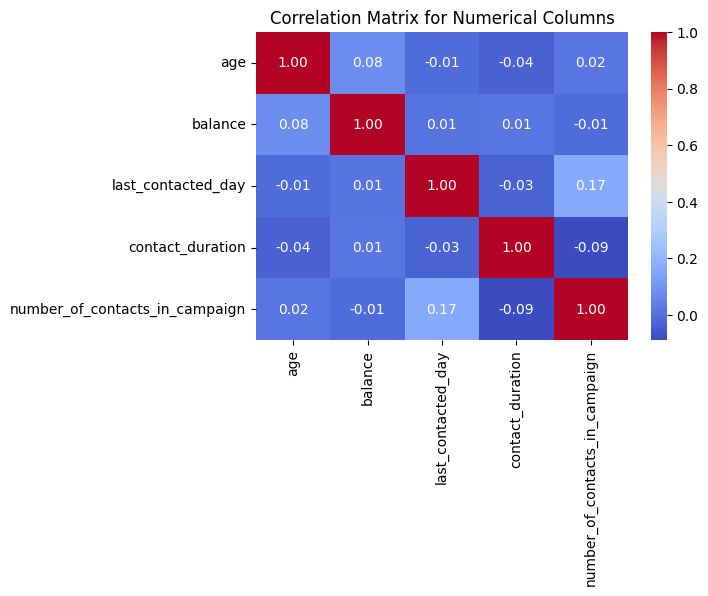

In [10]:
# Selecting only the numerical columns for correlation plot
numerical_cols = df.select_dtypes(include=['int64', 'float64'])

# Plotting the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Numerical Columns')
plt.show()

No correlations between any numerial columns such as their age & average yearly balance or contact duration and and number of contacts, there is a slight negative correlation which demonstrates that with the duration of contact reduces after each contact which makes logical sense as there are less queries and information being provided in subsequent calls & more being like follow-ups

Text(0.5, 1.0, 'Client Subscribed vs Not Subscribed by Job Type')

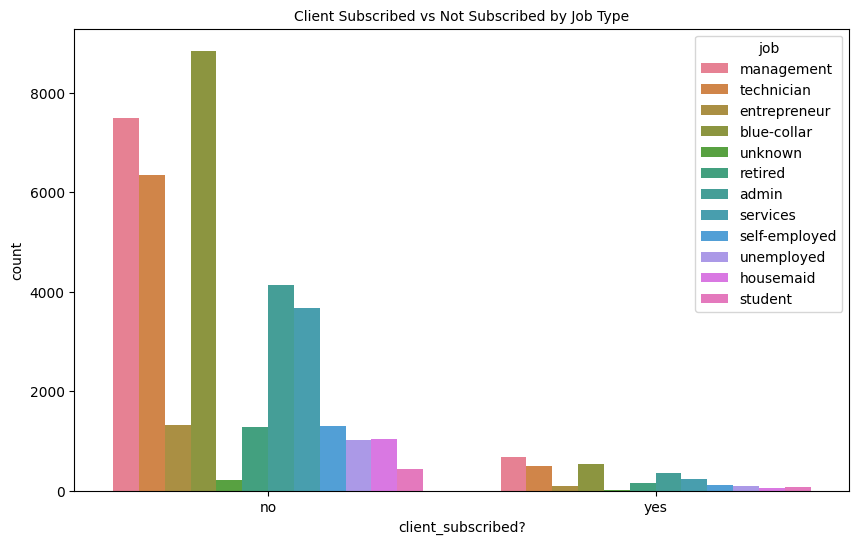

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(x='client_subscribed?', hue='job', data=df)
plt.title('Client Subscribed vs Not Subscribed by Job Type', fontsize=10)

Comments & Insights:

By focusing on the those clients that subscribed, we see that those in management level position, technicians, and those with blue-collar jobs make the highest percentage of subscribers.
These also make up the highest percentage of those who did not subscribe, but the blue collar jobs make up the highest who did not subscribe but not the highest in the category of subscribers.

Key insight would be to avoid targeting those people with blue collar jobs especially.

Text(0.5, 1.0, 'Client Subscribed vs Not Subscribed by Job Type')

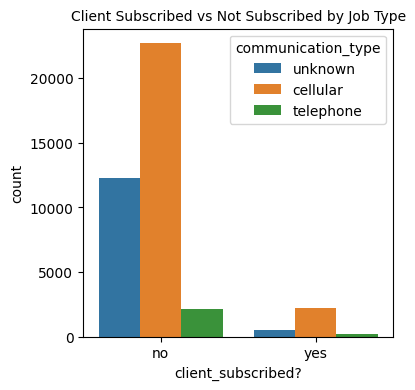

In [12]:
plt.figure(figsize=(4, 4))
sns.countplot(x='client_subscribed?', hue='communication_type', data=df)
plt.title('Client Subscribed vs Not Subscribed by Job Type', fontsize=10)

Comments:



*   The dataset is fairly imblanaced for customers who subscribed & didn't
so to train a ML model would result in a biased model, hence we require utliizing under or oversampling techniques e.g., SMOTE, ADASYN etc.



Text(0.5, 1.0, 'Client Subscribed vs Not Subscribed by Job Type')

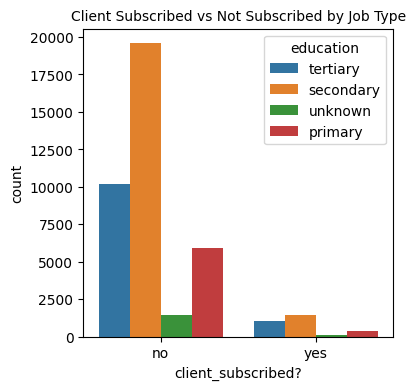

In [13]:
plt.figure(figsize=(4, 4))
sns.countplot(x='client_subscribed?', hue='education', data=df)
plt.title('Client Subscribed vs Not Subscribed by Job Type', fontsize=10)

This suggests that those with tertiary & secondary education levels outnumber other categories that have subscribed so would be our key focus.

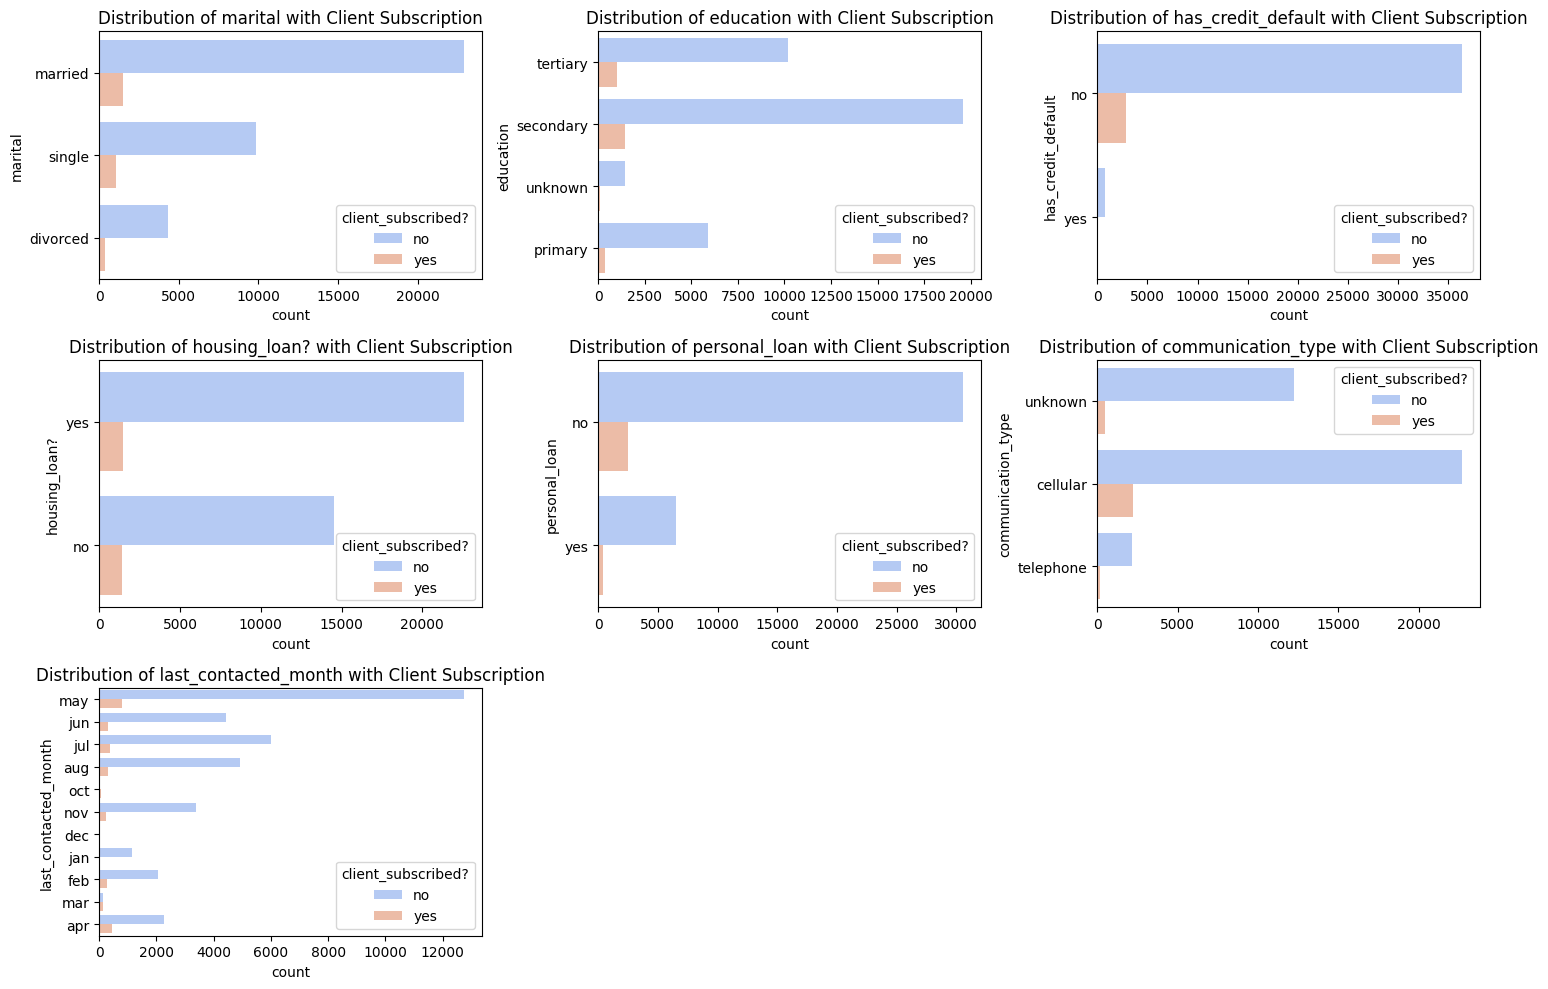

In [14]:
# Selecting only the numerical columns for correlation plot
categorical_cols = df.select_dtypes(include=['object'])
categorical_cols = categorical_cols.drop(columns=['job', 'client_subscribed?'])  # Exclude 'job' column

# Plotting the distribution of the categorical columns using bar charts
plt.figure(figsize=(15, 10))

# Loop through each categorical column and create bar charts
for i, column in enumerate(categorical_cols.columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=df[column], hue=df['client_subscribed?'], palette='coolwarm')
    plt.title(f'Distribution of {column} with Client Subscription')
    plt.tight_layout()

plt.show()

Comments & Insights:



1.   Those who already have personal loans make a higher percentage of those who have subscribed.
2.   Those customers who have defaulted their credits or loans before make a higher percentage / share of those who have subsribed to term deposits (~ 2500) so these could be the ones to target for calling. **These will be more likely to subscribe than people who have not defaulted before.**
3.   In the month of May, it seems it has generated the most amount of subscribers which could be due to some seasonality of prices or other external factors but an interesting find.
4.   The most effective method of contacting based on the data above is through cellular or mobile phones, so best to avoid landline numbers etc. Unknown could have included methods like email or in-person events but unfortunately there is no way of knowing this.



### 1st Layer: Pre-Campaign Customer Selection (Classification)

Feature Engineering / Train-Test Split



*   Firstly, since we are not using campaign related data, we require dropping the campaign related data, so we will drop the following columns from our data for training our first ML model:
          1. communication_type
          2. last_contacted_day  
          3. last_contacted_month
          4. contact_duration   
          5. number_of_contacts_in_campaign  
*    Then, we will perform One-hot-Encoding to convert categorial data into numerial format as ML models require numerical inputs & we will set drop_first as true to avoid multi-collinearity.
*    Lastly, we will split the data into train & test and use LazyClassifier to pick the best initial performing model for this random seed.



In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   age                             40000 non-null  int64 
 1   job                             40000 non-null  object
 2   marital                         40000 non-null  object
 3   education                       40000 non-null  object
 4   has_credit_default              40000 non-null  object
 5   balance                         40000 non-null  int64 
 6   housing_loan?                   40000 non-null  object
 7   personal_loan                   40000 non-null  object
 8   communication_type              40000 non-null  object
 9   last_contacted_day              40000 non-null  int64 
 10  last_contacted_month            40000 non-null  object
 11  contact_duration                40000 non-null  int64 
 12  number_of_contacts_in_campaign  40000 non-null

In [16]:
first_layer_df = df.drop(columns=['communication_type', 'last_contacted_day', 'last_contacted_month', 'contact_duration', 'number_of_contacts_in_campaign'])
first_layer_df_encoded = pd.get_dummies(first_layer_df, columns=['has_credit_default', 'job', 'marital', 'education', 'housing_loan?', 'personal_loan'], drop_first=True)  # drop_first removes one category to avoid multicollinearity


In [17]:
first_layer_df_encoded.head()

,age,balance,client_subscribed?,has_credit_default_yes,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,housing_loan?_yes,personal_loan_yes
0,58,2143,no,False,False,False,False,True,False,False,...,False,False,False,True,False,False,True,False,True,False
1,44,29,no,False,False,False,False,False,False,False,...,True,False,False,False,True,True,False,False,True,False
2,33,2,no,False,False,True,False,False,False,False,...,False,False,False,True,False,True,False,False,True,True
3,47,1506,no,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,True,False
4,33,1,no,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,True,False,False


In [18]:
# Split X and y
X = first_layer_df_encoded.drop(columns=['client_subscribed?'])
y = first_layer_df_encoded['client_subscribed?']


# Split the data into training and testing sets BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)


# Apply SMOTE only to the training data
smote = SMOTE(random_state=random_seed)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the class distribution after applying SMOTE
print("Class distribution in training set after balancing:")
print(y_train_balanced.value_counts())


# How SMOTE (Synthetic Minority Over-sampling) works?
# Identify Minority class, find nearest neigbors, create new synthetic sample
# through interpolation between data point and nearest neighbor through averaging
# their features values.

Class distribution in training set after balancing:
client_subscribed?
yes    27821
no     27821
Name: count, dtype: int64


In [19]:
# Check the class distribution after applying SMOTE
print("Class distribution in training set after balancing:")
print(y_test.value_counts())

Class distribution in training set after balancing:
client_subscribed?
no     9283
yes     717
Name: count, dtype: int64


In [20]:
# Select a random subset (e.g., 10% of the balanced training data) for faster model exploration
subset_percentage = 0.1
X_train_subset, y_train_subset = X_train_balanced.sample(frac=subset_percentage, random_state=random_seed), y_train_balanced.sample(frac=subset_percentage, random_state=random_seed)

In [21]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_subset)
X_test_scaled = scaler.transform(X_test)

# Use LazyPredict for initial model exploration
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, random_state=random_seed) # For getting quick overivew of a range of models on the dataset for justification
models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train_subset, y_test)


print("LazyPredict Model Performance:")
print(models)

 97%|█████████▋| 30/31 [00:21<00:00,  1.74it/s]

[LightGBM] [Info] Number of positive: 2741, number of negative: 2823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 5564, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492631 -> initscore=-0.029477
[LightGBM] [Info] Start training from score -0.029477


100%|██████████| 31/31 [00:22<00:00,  1.39it/s]

LazyPredict Model Performance:
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
BernoulliNB                        0.81               0.55    None      0.84   
NearestCentroid                    0.78               0.54    None      0.82   
PassiveAggressiveClassifier        0.78               0.54    None      0.82   
BaggingClassifier                  0.83               0.54    None      0.85   
LGBMClassifier                     0.86               0.53    None      0.86   
RandomForestClassifier             0.83               0.53    None      0.85   
LabelSpreading                     0.82               0.53    None      0.84   
ExtraTreeClassifier                0.77               0.53    None      0.81   
LabelPropagation                   0.81               0.53    None      0.84   
DecisionTreeClassifier             0.76               0.53    None      0.81   
ExtraTree

Model Selection: We will select LGBM Classifier as it performs the best on the subset of data in terms of F1-score. Below is the implementation of the model using the full dataset after utilizing oversampling techniques.

In [22]:
# Function to train and evaluate a model
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, model


# Split the data into training and testing sets BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)

# Apply SMOTE only to the training data
smote = SMOTE(random_state=random_seed)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)


# Import necessary libraries
from lightgbm import LGBMClassifier
# LGBM Classifier
lgbm_model = LGBMClassifier(random_state=random_seed, verbose=-1)
lgbm_accuracy, lgbm_model = train_and_evaluate(lgbm_model, X_train_scaled, X_test_scaled, y_train_balanced, y_test)
print(f"LGBM Classifier Accuracy: {lgbm_accuracy:.4f}")
# Print classification report for more detailed performance analysis
print("\nClassification Report:")# Predict on the test set
y_pred = lgbm_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))


LGBM Classifier Accuracy: 0.8688

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.93      0.93      0.93      9283
    Subscribed       0.12      0.13      0.13       717

      accuracy                           0.87     10000
     macro avg       0.53      0.53      0.53     10000
  weighted avg       0.87      0.87      0.87     10000



The recall for Class 1 is extremely poor, so the model performs poorly at identifying customers who will subscribe than customers who will not subscribe. This is expected due to the severe class imbalance in our dataset, we require further hyperamareter tuning techniques to enhance its performance as our goal is for the model to be competent in predicting customers who will subscribe accurately so we can identify who to call and who to filter out. Additionally, I will try undersampling the data to see if we can get better performance for class 1.

In [23]:
from imblearn.under_sampling import RandomUnderSampler


# Split the data into training and testing sets BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=random_seed) # This will make the majority class 1.5 times the minority class
# Fit and resample the training data
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)
print(y_train_balanced.value_counts())

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)


# Import necessary libraries
from lightgbm import LGBMClassifier
# LGBM Classifier
lgbm_model = LGBMClassifier(random_state=random_seed, verbose=-1)
lgbm_accuracy, lgbm_model = train_and_evaluate(lgbm_model, X_train_scaled, X_test_scaled, y_train_balanced, y_test)
print(f"LGBM Classifier Accuracy: {lgbm_accuracy:.4f}")
# Print classification report for more detailed performance analysis
print("\nClassification Report:")# Predict on the test set
y_pred = lgbm_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))


client_subscribed?
no     2046
yes    2046
Name: count, dtype: int64
LGBM Classifier Accuracy: 0.5873

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.94      0.59      0.73     11150
    Subscribed       0.09      0.52      0.15       850

      accuracy                           0.59     12000
     macro avg       0.51      0.55      0.44     12000
  weighted avg       0.88      0.59      0.69     12000



Now the recall for the Class 1 is significantly better however it is nowhere near our target of above 81%. There is another method to enhance recall score for class 1 where the class_weight paramter for the LightGBM can be manually adjusted, we can set a high weight for class 1 to force the model to focus more on the minority class. The default for class_weight is 'balanced' which calculates weight for each class based on its frequencey in the training data.

In [24]:
# Split data into training and test sets before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Example: Assuming class 0 (Not Subscribed) has more samples than class 1 (Subscribed)
class_weights = {'no': 1, 'yes': 35}  # Higher weight for class 1 (Subscribed)
# Adjusting class weights for LightGBM (automatically handles class imbalance)
lgbm_model_weighted = LGBMClassifier(random_state=42, class_weight=class_weights, verbose=-1)

# Train the model and evaluate performance
lgbm_accuracy_weighted, lgbm_model_weighted = train_and_evaluate(lgbm_model_weighted, X_train_scaled, X_test_scaled, y_train, y_test)

# Predict on the test set with class weighting applied
y_pred_weighted = lgbm_model_weighted.predict(X_test_scaled)

# Print classification report for the weighted model
print(f"LGBM Classifier Accuracy with Class Weights: {lgbm_accuracy_weighted:.4f}")
print("\nClassification Report (with class weights):")
print(classification_report(y_test, y_pred_weighted, target_names=['Not Subscribed', 'Subscribed']))


LGBM Classifier Accuracy with Class Weights: 0.2654

Classification Report (with class weights):
                precision    recall  f1-score   support

Not Subscribed       0.95      0.22      0.36      9283
    Subscribed       0.08      0.85      0.14       717

      accuracy                           0.27     10000
     macro avg       0.51      0.53      0.25     10000
  weighted avg       0.89      0.27      0.34     10000



Now we observe better results for recall for Class 1 as desired but it has greatly reduced the overall accuracy of our model.

### Smote Tomek:

This hybrid technique combines SMOTE (Synthetic Minority Over-Sampling) & Tomek Links. Tomek links are used to clean the dataset by undersampling the majority class. This is used to identify pairs in the dataset which are really similar or identicial and removes the instances from the majority class. With this combination, there is both an increase in the instances of the minority classes & lesser overlap between the data in the majority class.

In [25]:
from imblearn.combine import SMOTETomek


# Split the data into training and testing sets BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

# Initialize SMOTE Tomek
smote_tomek = SMOTETomek(random_state=random_seed)
# Fit and resample the training data
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)
# Check the class distribution after resampling
print(y_train_balanced.value_counts())

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)


client_subscribed?
no     24610
yes    24610
Name: count, dtype: int64


In [26]:
# LGBM Classifier
class_weights = {'no': 1, 'yes': 1}  # Higher weight for class 1 (Subscribed)

lgbm_model = LGBMClassifier(random_state=42, class_weight=class_weights, verbose=-1)

# lgbm_model = LGBMClassifier(random_state=random_seed, verbose=-1)
lgbm_accuracy, lgbm_model = train_and_evaluate(lgbm_model, X_train_scaled, X_test_scaled, y_train_balanced, y_test)

print(f"LGBM Classifier Accuracy: {lgbm_accuracy:.4f}")

# Predict on the test set
y_pred = lgbm_model.predict(X_test_scaled)

# Print classification report for more detailed performance analysis
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))

LGBM Classifier Accuracy: 0.8698

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.93      0.92      0.93     11150
    Subscribed       0.13      0.15      0.14       850

      accuracy                           0.87     12000
     macro avg       0.53      0.54      0.53     12000
  weighted avg       0.88      0.87      0.87     12000



### Smote ENN

SMOTE ENN (Synthetic Minority Over-sampling Technique with Edited Nearest Neighbors) is another hybrid resampling method. It will combine SMOTE for oversampling and using Edted Nearest Neighbours (ENN) for undersampling the minority class. ENN works by removing the instances with different class labels within typically a range of k=3, if those labels have different labels, those data points will be removed from our dataset.

In [27]:
# Import necessary libraries
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

# Initialize SMOTE ENN
smote_enn = SMOTEENN(random_state=random_seed)

# Fit and resample the training data
X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print(y_train_balanced.value_counts())

client_subscribed?
yes    19523
no     12640
Name: count, dtype: int64


In [28]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# LGBM Classifier
lgbm_model = LGBMClassifier(random_state=random_seed, verbose=-1)
lgbm_accuracy, lgbm_model = train_and_evaluate(lgbm_model, X_train_scaled, X_test_scaled, y_train_balanced, y_test)

print(f"LGBM Classifier Accuracy: {lgbm_accuracy:.4f}")

# Predict on the test set
y_pred = lgbm_model.predict(X_test_scaled)

# Print classification report for more detailed performance analysis
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))


LGBM Classifier Accuracy: 0.8240

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.94      0.87      0.90     11150
    Subscribed       0.12      0.23      0.16       850

      accuracy                           0.82     12000
     macro avg       0.53      0.55      0.53     12000
  weighted avg       0.88      0.82      0.85     12000



So far, with SMOTE ENN & SMOTE Tomek, the results have been more or less the same with regards to both classes even when using different class weights for LGBM Classifier. The next stage is to perform hyperparameter tuning using hyperopt for the LGB model, we will select the new training dataset with SMOTE ENN as an example to inspect whether our results for the subscribed class greatly improves or not along with a high accuracy score (>81% required).

### Hyperparameter tuning

5-Fold Cross Validation:

Splitting the data into 5 Folds, each fold will contain roughly the same proportion of data. The model is trained & tested 5 times, in each iteration, 4 folds are used for training and the remaining for testing or validation. After 5 iterations, the performance scores from each iteration are averaged.



In [34]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Define a search space for hyperparameters
search_space = {
    'num_leaves': hp.choice('num_leaves', [31, 50, 70]),  # 3 values
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),  # Slightly narrowed range
    'max_depth': hp.choice('max_depth', [5, 10, 15]),  # 3 values
    'n_estimators': hp.choice('n_estimators', [100, 300, 500]),  # 3 values
    'min_child_samples': hp.choice('min_child_samples', [20, 50, 70]),  # 3 values
    'subsample': hp.uniform('subsample', 0.7, 0.9),  # Narrowed range for subsampling
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 0.9),  # Narrowed range for column sampling
    'class_weight': hp.choice('class_weight', ['balanced', None]),  # No change here
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 0.5),  # regularization
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 0.5),  # regularization
}


# Define 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

# Objective function for HyperOpt
def objective(params):
    # Initialize LGBMClassifier with the current set of hyperparameters
    lgbm_model = LGBMClassifier(random_state=random_seed, **params)

    # Perform 5-fold cross-validation and return the average accuracy score
    accuracy = cross_val_score(lgbm_model, X_train_scaled, y_train_balanced, cv=cv, scoring='accuracy').mean()

    # HyperOpt minimizes the objective function, so we return the negative accuracy
    return {'loss': -accuracy, 'status': STATUS_OK}

# Run HyperOpt optimization with 5-fold cross-validation
trials = Trials()
best_params = fmin(fn=objective,
                   space=search_space,
                   algo=tpe.suggest,
                   max_evals=50,  # Number of evaluations
                   trials=trials,
                   rstate=np.random.default_rng(random_seed))

# Print the best parameters
print("Best Hyperparameters:", best_params)

100%|██████████| 50/50 [00:00<?, ?trial/s, best loss=?]
Best Hyperparameters: {'class_weight': 1, 'colsample_bytree': 0.7718058379726002, 'learning_rate': 0.17245087710163448, 'max_depth': 2, 'min_child_samples': 0, 'n_estimators': 2, 'num_leaves': 2, 'reg_alpha': 0.05496921105543315, 'reg_lambda': 0.03729081805680403, 'subsample': 0.890528043386437}


In [36]:
# Print the best parameters
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'class_weight': 1, 'colsample_bytree': 0.7718058379726002, 'learning_rate': 0.17245087710163448, 'max_depth': 2, 'min_child_samples': 0, 'n_estimators': 2, 'num_leaves': 2, 'reg_alpha': 0.05496921105543315, 'reg_lambda': 0.03729081805680403, 'subsample': 0.890528043386437}


In [45]:
# LGBM Classifier

# Train the LGBM model with the best hyperparameters found
best_lgbm_model = LGBMClassifier(
    num_leaves=int(best_params['num_leaves']), # Cast num_leaves to int
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']), # Cast max_depth to int
    n_estimators=int(best_params['n_estimators']), # Cast n_estimators to int
    min_child_samples=int(best_params['min_child_samples']), # Cast min_child_samples to int
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    class_weight='balanced' if best_params['class_weight'] > 0.5 else None, # Ensure class_weight is 'balanced' or None
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=random_seed
)



lgbm_model = LGBMClassifier(random_state=42, class_weight=class_weights, verbose=-1)

# Perform 5-fold cross-validation on the best model
cv_scores = cross_val_score(best_lgbm_model, X_train_scaled, y_train_balanced, cv=cv, scoring='accuracy')

# Print average accuracy across the 5 folds
print(f"Average Accuracy across 5 folds: {cv_scores.mean():.4f}")

# Train on the entire training data and evaluate on test data
best_lgbm_model.fit(X_train_scaled, y_train_balanced)
y_pred = best_lgbm_model.predict(X_test_scaled)

# Print the classification report on the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))

Average Accuracy across 5 folds: 0.6766

Classification Report on Test Set:
                precision    recall  f1-score   support

Not Subscribed       0.93      0.64      0.76      7423
    Subscribed       0.08      0.42      0.14       577

      accuracy                           0.62      8000
     macro avg       0.51      0.53      0.45      8000
  weighted avg       0.87      0.62      0.71      8000



### 2nd Layer: Call Persistence (Retention Model)

### 3rd Layer: Subscriber Segmentation (Unsupervised Learning)

### Results Interpretation

### Conclusion & Future Work